In [1]:
import os

max_files = 50  # number of files to print
count = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
        if count >= max_files:
            break
    if count >= max_files:
        break

/kaggle/input/nih-chest-x-rays-preprocessed-version/README_CHESTXRAY.pdf
/kaggle/input/nih-chest-x-rays-preprocessed-version/BBox_List_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/test_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/Data_Entry_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/train_val_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006199_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004833_016.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006260_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004911_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004186_007.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004459_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00005004_001.png
/kaggle/input/nih-chest-x-rays-preproc

In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import wandb
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, confusion_matrix, multilabel_confusion_matrix
import numpy as np
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# ---------------- CONFIG ---------------- #
CONFIG = {
    "model": "efficientnet_b3_implementation",
    "batch_size": 4,  # Reduced due to larger image size and model
    "learning_rate": 0.00005,
    "epochs": 15,
    "num_workers": 2,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "data_dir": "/kaggle/input/nih-chest-x-rays-preprocessed-version",  # <- CHANGE to your Kaggle dataset path
    "patience": 5,
    "seed": 22,
    "image_size": 300,  # EfficientNet-B3's native resolution
}

In [5]:
print(CONFIG["device"])

cuda


In [6]:
# ---------------- TRANSFORMS ---------------- #
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(CONFIG["image_size"]),  # Use config
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize(CONFIG["image_size"] + 28),  # Add margin
    transforms.CenterCrop(CONFIG["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [7]:
# ---------------- MODEL ---------------- #
model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
# EfficientNet classifier is a Sequential module: [Dropout, Linear]
# We need to access the Linear layer (index 1) to get in_features
num_features = model.classifier[1].in_features
model.classifier = nn.Linear(num_features, 14)
model = model.to(CONFIG["device"])

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 165MB/s]


In [8]:
# ---------------- LOSS ---------------- #
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [9]:
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)

In [10]:
# ---------------- DATA ---------------- #
data_path = CONFIG["data_dir"]
csv_file = os.path.join(data_path, "Data_Entry_2017.csv")
df = pd.read_csv(csv_file)

In [11]:
image_folders = [os.path.join(data_path, f"images_{str(i).zfill(3)}", "images") for i in range(1, 13)]
image_to_folder = {}
for folder in image_folders:
    if os.path.exists(folder):
        for img_file in os.listdir(folder):
            if img_file.endswith('.png'):
                image_to_folder[img_file] = folder


In [12]:
df = df[df['Image Index'].isin(image_to_folder.keys())]

In [13]:
unique_patients = df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.02, random_state= 42)
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.052, random_state=CONFIG["seed"])

In [14]:
train_df = df[df['Patient ID'].isin(train_patients)]
val_df   = df[df['Patient ID'].isin(val_patients)]
test_df  = df[df['Patient ID'].isin(test_patients)]

In [15]:
disease_list = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

In [16]:
def get_label_vector(labels_str):
    labels = labels_str.split('|')
    if labels == ['No Finding']:
        return [0] * len(disease_list)
    else:
        return [1 if disease in labels else 0 for disease in disease_list]

In [17]:
class CheXNetDataset(Dataset):
    def __init__(self, dataframe, image_to_folder, transform=None):
        self.dataframe = dataframe
        self.image_to_folder = image_to_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image Index']
        folder = self.image_to_folder[img_name]
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels_str = self.dataframe.iloc[idx]['Finding Labels']
        labels = torch.tensor(get_label_vector(labels_str), dtype=torch.float)
        return image, labels

In [18]:
trainloader = DataLoader(CheXNetDataset(train_df, image_to_folder, transform=transform_train),
                         batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
valloader = DataLoader(CheXNetDataset(val_df, image_to_folder, transform=transform_test),
                       batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])
testloader = DataLoader(CheXNetDataset(test_df, image_to_folder, transform=transform_test),
                        batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

In [19]:
# ---------------- METRICS ---------------- #
def get_optimal_thresholds(labels, preds):
    thresholds = []
    for i in range(preds.shape[1]):
        precision, recall, thresh = precision_recall_curve(labels[:, i], preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresh[np.argmax(f1_scores)] if len(thresh) > 0 else 0.5
        thresholds.append(best_threshold)
    return thresholds

In [20]:
def evaluate(model, loader, criterion, device, desc="[Test]"):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=desc):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    thresholds = get_optimal_thresholds(all_labels, all_preds)

    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        preds_binary[:, i] = (all_preds[:, i] > thresholds[i]).astype(int)

    auc_scores = [roc_auc_score(all_labels[:, i], all_preds[:, i]) for i in range(14)]
    f1_scores = [f1_score(all_labels[:, i], preds_binary[:, i]) for i in range(14)]

    avg_auc = np.mean(auc_scores)
    avg_f1 = np.mean(f1_scores)

    for i, disease in enumerate(disease_list):
        print(f"{desc} {disease} AUC: {auc_scores[i]:.4f} | F1: {f1_scores[i]:.4f}")

    print(f"{desc} Avg AUC: {avg_auc:.4f}, Avg F1: {avg_f1:.4f}")

    return {
        "loss": running_loss / len(loader),
        "avg_auc": avg_auc,
        "avg_f1": avg_f1,
        "auc_dict": dict(zip(disease_list, auc_scores)),
        "f1_dict": dict(zip(disease_list, f1_scores)),
        "thresholds": dict(zip(disease_list, thresholds))
    }


In [21]:
# ---------------- TRAINING ---------------- #
def train(epoch, model, trainloader, optimizer, criterion, CONFIG):
    device = CONFIG["device"]
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]", leave=True)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({"loss": running_loss / (i + 1)})
    train_loss = running_loss / len(trainloader)
    return train_loss


In [22]:
def validate(model, valloader, criterion, device):
    return evaluate(model, valloader, criterion, device, desc="[Validate]")


In [23]:
# ---------------- MAIN LOOP ---------------- #
checkpoint_dir = "models"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_auc = 0.0
patience_counter = 0

# Lists to store losses for plotting
train_losses = []
val_losses = []
epochs_list = []

print("Starting training...")
print("-" * 80)

for epoch in range(CONFIG["epochs"]):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
    print("-" * 40)
    
    # Training
    train_loss = train(epoch, model, trainloader, optimizer, criterion, CONFIG)
    
    # Validation
    val_stats = validate(model, valloader, criterion, CONFIG["device"])
    
    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_stats["loss"])
    epochs_list.append(epoch + 1)
    
    # Display epoch summary
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_stats['loss']:.4f}")
    print(f"Validation AUC: {val_stats['avg_auc']:.4f}")
    print(f"Validation F1: {val_stats['avg_f1']:.4f}")
    
    scheduler.step(val_stats["loss"])

    if val_stats["avg_auc"] > best_val_auc:
        best_val_auc = val_stats["avg_auc"]
        patience_counter = 0
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        checkpoint_path = os.path.join(checkpoint_dir, f"best_model_{timestamp}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✓ NEW BEST MODEL! Saved at {checkpoint_path}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{CONFIG['patience']}")
        if patience_counter >= CONFIG["patience"]:
            print("Early stopping triggered.")
            break

print("\nTraining completed!")
print("-" * 80)

Starting training...
--------------------------------------------------------------------------------

Epoch 1/15
----------------------------------------


Epoch 1/15 [Train]:   0%|          | 0/25980 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1476 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8077 | F1: 0.4186
[Validate] Cardiomegaly AUC: 0.8493 | F1: 0.2847
[Validate] Consolidation AUC: 0.7907 | F1: 0.2275
[Validate] Edema AUC: 0.8855 | F1: 0.2505
[Validate] Effusion AUC: 0.8623 | F1: 0.5168
[Validate] Emphysema AUC: 0.8866 | F1: 0.3636
[Validate] Fibrosis AUC: 0.8162 | F1: 0.1545
[Validate] Hernia AUC: 0.9815 | F1: 0.0845
[Validate] Infiltration AUC: 0.7080 | F1: 0.4306
[Validate] Mass AUC: 0.7864 | F1: 0.3244
[Validate] Nodule AUC: 0.7183 | F1: 0.2585
[Validate] Pleural_Thickening AUC: 0.7696 | F1: 0.1558
[Validate] Pneumonia AUC: 0.7637 | F1: 0.1026
[Validate] Pneumothorax AUC: 0.8710 | F1: 0.3594
[Validate] Avg AUC: 0.8212, Avg F1: 0.2809
Training Loss: 0.0465
Validation Loss: 0.0415
Validation AUC: 0.8212
Validation F1: 0.2809
✓ NEW BEST MODEL! Saved at models/best_model_20250920-064926.pth

Epoch 2/15
----------------------------------------


Epoch 2/15 [Train]:   0%|          | 0/25980 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1476 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8212 | F1: 0.4402
[Validate] Cardiomegaly AUC: 0.8807 | F1: 0.3641
[Validate] Consolidation AUC: 0.7947 | F1: 0.2600
[Validate] Edema AUC: 0.8890 | F1: 0.2607
[Validate] Effusion AUC: 0.8674 | F1: 0.5337
[Validate] Emphysema AUC: 0.8990 | F1: 0.4423
[Validate] Fibrosis AUC: 0.7818 | F1: 0.1579
[Validate] Hernia AUC: 0.9880 | F1: 0.1250
[Validate] Infiltration AUC: 0.7160 | F1: 0.4330
[Validate] Mass AUC: 0.8009 | F1: 0.3575
[Validate] Nodule AUC: 0.7494 | F1: 0.2931
[Validate] Pleural_Thickening AUC: 0.7997 | F1: 0.2059
[Validate] Pneumonia AUC: 0.7843 | F1: 0.1017
[Validate] Pneumothorax AUC: 0.8758 | F1: 0.3538
[Validate] Avg AUC: 0.8320, Avg F1: 0.3092
Training Loss: 0.0436
Validation Loss: 0.0413
Validation AUC: 0.8320
Validation F1: 0.3092
✓ NEW BEST MODEL! Saved at models/best_model_20250920-073247.pth

Epoch 3/15
----------------------------------------


Epoch 3/15 [Train]:   0%|          | 0/25980 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1476 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8298 | F1: 0.4575
[Validate] Cardiomegaly AUC: 0.8800 | F1: 0.3980
[Validate] Consolidation AUC: 0.7701 | F1: 0.2572
[Validate] Edema AUC: 0.8864 | F1: 0.2500
[Validate] Effusion AUC: 0.8766 | F1: 0.5435
[Validate] Emphysema AUC: 0.9275 | F1: 0.4341
[Validate] Fibrosis AUC: 0.7973 | F1: 0.1519
[Validate] Hernia AUC: 0.9920 | F1: 0.0000
[Validate] Infiltration AUC: 0.7145 | F1: 0.4362
[Validate] Mass AUC: 0.8042 | F1: 0.3592
[Validate] Nodule AUC: 0.7618 | F1: 0.2948
[Validate] Pleural_Thickening AUC: 0.8063 | F1: 0.2444
[Validate] Pneumonia AUC: 0.7863 | F1: 0.1139
[Validate] Pneumothorax AUC: 0.8837 | F1: 0.3897
[Validate] Avg AUC: 0.8369, Avg F1: 0.3093
Training Loss: 0.0425
Validation Loss: 0.0407
Validation AUC: 0.8369
Validation F1: 0.3093
✓ NEW BEST MODEL! Saved at models/best_model_20250920-081610.pth

Epoch 4/15
----------------------------------------


Epoch 4/15 [Train]:   0%|          | 0/25980 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1476 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8255 | F1: 0.4376
[Validate] Cardiomegaly AUC: 0.8785 | F1: 0.3920
[Validate] Consolidation AUC: 0.7809 | F1: 0.2587
[Validate] Edema AUC: 0.8887 | F1: 0.2652
[Validate] Effusion AUC: 0.8750 | F1: 0.5460
[Validate] Emphysema AUC: 0.9337 | F1: 0.4416
[Validate] Fibrosis AUC: 0.7922 | F1: 0.1778
[Validate] Hernia AUC: 0.9974 | F1: 0.3333
[Validate] Infiltration AUC: 0.7289 | F1: 0.4568
[Validate] Mass AUC: 0.8030 | F1: 0.3439
[Validate] Nodule AUC: 0.7619 | F1: 0.2895
[Validate] Pleural_Thickening AUC: 0.8039 | F1: 0.2222
[Validate] Pneumonia AUC: 0.7714 | F1: 0.1222
[Validate] Pneumothorax AUC: 0.8649 | F1: 0.3329
[Validate] Avg AUC: 0.8361, Avg F1: 0.3300
Training Loss: 0.0418
Validation Loss: 0.0409
Validation AUC: 0.8361
Validation F1: 0.3300
No improvement. Patience: 1/5

Epoch 5/15
----------------------------------------


Epoch 5/15 [Train]:   0%|          | 0/25980 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1476 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8305 | F1: 0.4622
[Validate] Cardiomegaly AUC: 0.8790 | F1: 0.4097
[Validate] Consolidation AUC: 0.7723 | F1: 0.2483
[Validate] Edema AUC: 0.8976 | F1: 0.2712
[Validate] Effusion AUC: 0.8741 | F1: 0.5518
[Validate] Emphysema AUC: 0.9277 | F1: 0.4750
[Validate] Fibrosis AUC: 0.7964 | F1: 0.1772
[Validate] Hernia AUC: 0.9982 | F1: 0.3077
[Validate] Infiltration AUC: 0.7142 | F1: 0.4424
[Validate] Mass AUC: 0.8106 | F1: 0.3480
[Validate] Nodule AUC: 0.7594 | F1: 0.2887
[Validate] Pleural_Thickening AUC: 0.8109 | F1: 0.2387
[Validate] Pneumonia AUC: 0.7858 | F1: 0.1088
[Validate] Pneumothorax AUC: 0.8912 | F1: 0.3955
[Validate] Avg AUC: 0.8391, Avg F1: 0.3375
Training Loss: 0.0413
Validation Loss: 0.0408
Validation AUC: 0.8391
Validation F1: 0.3375
✓ NEW BEST MODEL! Saved at models/best_model_20250920-094302.pth

Epoch 6/15
----------------------------------------


Epoch 6/15 [Train]:   0%|          | 0/25980 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1476 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8378 | F1: 0.4724
[Validate] Cardiomegaly AUC: 0.8939 | F1: 0.4456
[Validate] Consolidation AUC: 0.7870 | F1: 0.2623
[Validate] Edema AUC: 0.8956 | F1: 0.2770
[Validate] Effusion AUC: 0.8788 | F1: 0.5519
[Validate] Emphysema AUC: 0.9377 | F1: 0.4727
[Validate] Fibrosis AUC: 0.8068 | F1: 0.2055
[Validate] Hernia AUC: 0.9979 | F1: 0.2609
[Validate] Infiltration AUC: 0.7159 | F1: 0.4430
[Validate] Mass AUC: 0.8245 | F1: 0.3573
[Validate] Nodule AUC: 0.7764 | F1: 0.3037
[Validate] Pleural_Thickening AUC: 0.8223 | F1: 0.2617
[Validate] Pneumonia AUC: 0.7977 | F1: 0.1127
[Validate] Pneumothorax AUC: 0.8964 | F1: 0.4103
[Validate] Avg AUC: 0.8478, Avg F1: 0.3455
Training Loss: 0.0401
Validation Loss: 0.0399
Validation AUC: 0.8478
Validation F1: 0.3455
✓ NEW BEST MODEL! Saved at models/best_model_20250920-102638.pth

Epoch 7/15
----------------------------------------


Epoch 7/15 [Train]:   0%|          | 0/25980 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1476 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8403 | F1: 0.4679
[Validate] Cardiomegaly AUC: 0.8951 | F1: 0.4375
[Validate] Consolidation AUC: 0.7950 | F1: 0.2837
[Validate] Edema AUC: 0.8985 | F1: 0.2663
[Validate] Effusion AUC: 0.8796 | F1: 0.5570
[Validate] Emphysema AUC: 0.9371 | F1: 0.4609
[Validate] Fibrosis AUC: 0.8129 | F1: 0.2080
[Validate] Hernia AUC: 0.9977 | F1: 0.2353
[Validate] Infiltration AUC: 0.7228 | F1: 0.4462
[Validate] Mass AUC: 0.8246 | F1: 0.3525
[Validate] Nodule AUC: 0.7812 | F1: 0.3113
[Validate] Pleural_Thickening AUC: 0.8278 | F1: 0.2596
[Validate] Pneumonia AUC: 0.8017 | F1: 0.1364
[Validate] Pneumothorax AUC: 0.8865 | F1: 0.3753
[Validate] Avg AUC: 0.8500, Avg F1: 0.3427
Training Loss: 0.0398
Validation Loss: 0.0401
Validation AUC: 0.8500
Validation F1: 0.3427
✓ NEW BEST MODEL! Saved at models/best_model_20250920-111016.pth

Epoch 8/15
----------------------------------------


Epoch 8/15 [Train]:   0%|          | 0/25980 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1476 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8418 | F1: 0.4667
[Validate] Cardiomegaly AUC: 0.8966 | F1: 0.4286
[Validate] Consolidation AUC: 0.7975 | F1: 0.2789
[Validate] Edema AUC: 0.8987 | F1: 0.2713
[Validate] Effusion AUC: 0.8792 | F1: 0.5535
[Validate] Emphysema AUC: 0.9387 | F1: 0.4588
[Validate] Fibrosis AUC: 0.8118 | F1: 0.2154
[Validate] Hernia AUC: 0.9981 | F1: 0.2857
[Validate] Infiltration AUC: 0.7196 | F1: 0.4397
[Validate] Mass AUC: 0.8242 | F1: 0.3521
[Validate] Nodule AUC: 0.7787 | F1: 0.3010
[Validate] Pleural_Thickening AUC: 0.8275 | F1: 0.2654
[Validate] Pneumonia AUC: 0.7972 | F1: 0.1222
[Validate] Pneumothorax AUC: 0.8878 | F1: 0.3939
[Validate] Avg AUC: 0.8498, Avg F1: 0.3452
Training Loss: 0.0397
Validation Loss: 0.0399
Validation AUC: 0.8498
Validation F1: 0.3452
No improvement. Patience: 1/5

Epoch 9/15
----------------------------------------


Epoch 9/15 [Train]:   0%|          | 0/25980 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1476 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8390 | F1: 0.4687
[Validate] Cardiomegaly AUC: 0.8943 | F1: 0.4387
[Validate] Consolidation AUC: 0.7939 | F1: 0.2773
[Validate] Edema AUC: 0.9011 | F1: 0.2746
[Validate] Effusion AUC: 0.8781 | F1: 0.5529
[Validate] Emphysema AUC: 0.9361 | F1: 0.4545
[Validate] Fibrosis AUC: 0.7962 | F1: 0.2171
[Validate] Hernia AUC: 0.9978 | F1: 0.2222
[Validate] Infiltration AUC: 0.7197 | F1: 0.4408
[Validate] Mass AUC: 0.8185 | F1: 0.3184
[Validate] Nodule AUC: 0.7690 | F1: 0.2759
[Validate] Pleural_Thickening AUC: 0.8296 | F1: 0.2721
[Validate] Pneumonia AUC: 0.7990 | F1: 0.1329
[Validate] Pneumothorax AUC: 0.8855 | F1: 0.3994
[Validate] Avg AUC: 0.8470, Avg F1: 0.3390
Training Loss: 0.0395
Validation Loss: 0.0402
Validation AUC: 0.8470
Validation F1: 0.3390
No improvement. Patience: 2/5

Epoch 10/15
----------------------------------------


Epoch 10/15 [Train]:   0%|          | 0/25980 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1476 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8428 | F1: 0.4757
[Validate] Cardiomegaly AUC: 0.8967 | F1: 0.4286
[Validate] Consolidation AUC: 0.7988 | F1: 0.2699
[Validate] Edema AUC: 0.8978 | F1: 0.2844
[Validate] Effusion AUC: 0.8782 | F1: 0.5570
[Validate] Emphysema AUC: 0.9404 | F1: 0.4387
[Validate] Fibrosis AUC: 0.8145 | F1: 0.2333
[Validate] Hernia AUC: 0.9985 | F1: 0.4000
[Validate] Infiltration AUC: 0.7154 | F1: 0.4385
[Validate] Mass AUC: 0.8236 | F1: 0.3508
[Validate] Nodule AUC: 0.7779 | F1: 0.2962
[Validate] Pleural_Thickening AUC: 0.8329 | F1: 0.2622
[Validate] Pneumonia AUC: 0.7992 | F1: 0.1322
[Validate] Pneumothorax AUC: 0.8856 | F1: 0.3994
[Validate] Avg AUC: 0.8502, Avg F1: 0.3548
Training Loss: 0.0394
Validation Loss: 0.0397
Validation AUC: 0.8502
Validation F1: 0.3548
✓ NEW BEST MODEL! Saved at models/best_model_20250920-132040.pth

Epoch 11/15
----------------------------------------


Epoch 11/15 [Train]:   0%|          | 0/25980 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1476 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8417 | F1: 0.4699
[Validate] Cardiomegaly AUC: 0.8988 | F1: 0.4259
[Validate] Consolidation AUC: 0.7970 | F1: 0.2793
[Validate] Edema AUC: 0.8992 | F1: 0.2805
[Validate] Effusion AUC: 0.8780 | F1: 0.5565
[Validate] Emphysema AUC: 0.9363 | F1: 0.4269
[Validate] Fibrosis AUC: 0.8222 | F1: 0.2345
[Validate] Hernia AUC: 0.9986 | F1: 0.3333
[Validate] Infiltration AUC: 0.7178 | F1: 0.4436
[Validate] Mass AUC: 0.8213 | F1: 0.3590
[Validate] Nodule AUC: 0.7746 | F1: 0.2783
[Validate] Pleural_Thickening AUC: 0.8321 | F1: 0.2817
[Validate] Pneumonia AUC: 0.7949 | F1: 0.1259
[Validate] Pneumothorax AUC: 0.8833 | F1: 0.3831
[Validate] Avg AUC: 0.8497, Avg F1: 0.3485
Training Loss: 0.0392
Validation Loss: 0.0398
Validation AUC: 0.8497
Validation F1: 0.3485
No improvement. Patience: 1/5

Epoch 12/15
----------------------------------------


Epoch 12/15 [Train]:   0%|          | 0/25980 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1476 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8453 | F1: 0.4716
[Validate] Cardiomegaly AUC: 0.8915 | F1: 0.4450
[Validate] Consolidation AUC: 0.8028 | F1: 0.2873
[Validate] Edema AUC: 0.8988 | F1: 0.2784
[Validate] Effusion AUC: 0.8794 | F1: 0.5554
[Validate] Emphysema AUC: 0.9334 | F1: 0.4435
[Validate] Fibrosis AUC: 0.8114 | F1: 0.2063
[Validate] Hernia AUC: 0.9984 | F1: 0.3636
[Validate] Infiltration AUC: 0.7189 | F1: 0.4404
[Validate] Mass AUC: 0.8247 | F1: 0.3547
[Validate] Nodule AUC: 0.7721 | F1: 0.2744
[Validate] Pleural_Thickening AUC: 0.8346 | F1: 0.2632
[Validate] Pneumonia AUC: 0.7989 | F1: 0.1241
[Validate] Pneumothorax AUC: 0.8824 | F1: 0.3879
[Validate] Avg AUC: 0.8495, Avg F1: 0.3497
Training Loss: 0.0391
Validation Loss: 0.0396
Validation AUC: 0.8495
Validation F1: 0.3497
No improvement. Patience: 2/5

Epoch 13/15
----------------------------------------


Epoch 13/15 [Train]:   0%|          | 0/25980 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe604b70040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe604b70040>^
Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    ^self._shutdown_workers()^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
^ ^^  ^ ^ ^^ ^ ^^^^^^

[Validate]:   0%|          | 0/1476 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8468 | F1: 0.4737
[Validate] Cardiomegaly AUC: 0.8932 | F1: 0.4340
[Validate] Consolidation AUC: 0.8043 | F1: 0.2956
[Validate] Edema AUC: 0.8953 | F1: 0.2730
[Validate] Effusion AUC: 0.8783 | F1: 0.5553
[Validate] Emphysema AUC: 0.9349 | F1: 0.4224
[Validate] Fibrosis AUC: 0.8221 | F1: 0.2047
[Validate] Hernia AUC: 0.9982 | F1: 0.3636
[Validate] Infiltration AUC: 0.7201 | F1: 0.4420
[Validate] Mass AUC: 0.8230 | F1: 0.3547
[Validate] Nodule AUC: 0.7740 | F1: 0.2923
[Validate] Pleural_Thickening AUC: 0.8331 | F1: 0.2692
[Validate] Pneumonia AUC: 0.7927 | F1: 0.1149
[Validate] Pneumothorax AUC: 0.8879 | F1: 0.3976
[Validate] Avg AUC: 0.8503, Avg F1: 0.3495
Training Loss: 0.0391
Validation Loss: 0.0395
Validation AUC: 0.8503
Validation F1: 0.3495
✓ NEW BEST MODEL! Saved at models/best_model_20250920-153103.pth

Epoch 14/15
----------------------------------------


Epoch 14/15 [Train]:   0%|          | 0/25980 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1476 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8434 | F1: 0.4700
[Validate] Cardiomegaly AUC: 0.8934 | F1: 0.4380
[Validate] Consolidation AUC: 0.8032 | F1: 0.2968
[Validate] Edema AUC: 0.8970 | F1: 0.2664
[Validate] Effusion AUC: 0.8781 | F1: 0.5595
[Validate] Emphysema AUC: 0.9311 | F1: 0.4106
[Validate] Fibrosis AUC: 0.8196 | F1: 0.2151
[Validate] Hernia AUC: 0.9987 | F1: 0.4444
[Validate] Infiltration AUC: 0.7230 | F1: 0.4413
[Validate] Mass AUC: 0.8236 | F1: 0.3574
[Validate] Nodule AUC: 0.7717 | F1: 0.2865
[Validate] Pleural_Thickening AUC: 0.8320 | F1: 0.2645
[Validate] Pneumonia AUC: 0.7978 | F1: 0.1333
[Validate] Pneumothorax AUC: 0.8777 | F1: 0.3972
[Validate] Avg AUC: 0.8493, Avg F1: 0.3558
Training Loss: 0.0389
Validation Loss: 0.0398
Validation AUC: 0.8493
Validation F1: 0.3558
No improvement. Patience: 1/5

Epoch 15/15
----------------------------------------


Epoch 15/15 [Train]:   0%|          | 0/25980 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1476 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8449 | F1: 0.4798
[Validate] Cardiomegaly AUC: 0.8925 | F1: 0.4314
[Validate] Consolidation AUC: 0.8000 | F1: 0.2824
[Validate] Edema AUC: 0.8976 | F1: 0.2721
[Validate] Effusion AUC: 0.8784 | F1: 0.5574
[Validate] Emphysema AUC: 0.9328 | F1: 0.3887
[Validate] Fibrosis AUC: 0.8121 | F1: 0.1951
[Validate] Hernia AUC: 0.9988 | F1: 0.3333
[Validate] Infiltration AUC: 0.7198 | F1: 0.4365
[Validate] Mass AUC: 0.8242 | F1: 0.3527
[Validate] Nodule AUC: 0.7715 | F1: 0.2760
[Validate] Pleural_Thickening AUC: 0.8340 | F1: 0.2667
[Validate] Pneumonia AUC: 0.7937 | F1: 0.1231
[Validate] Pneumothorax AUC: 0.8732 | F1: 0.3613
[Validate] Avg AUC: 0.8481, Avg F1: 0.3397
Training Loss: 0.0389
Validation Loss: 0.0401
Validation AUC: 0.8481
Validation F1: 0.3397
No improvement. Patience: 2/5

Training completed!
--------------------------------------------------------------------------------


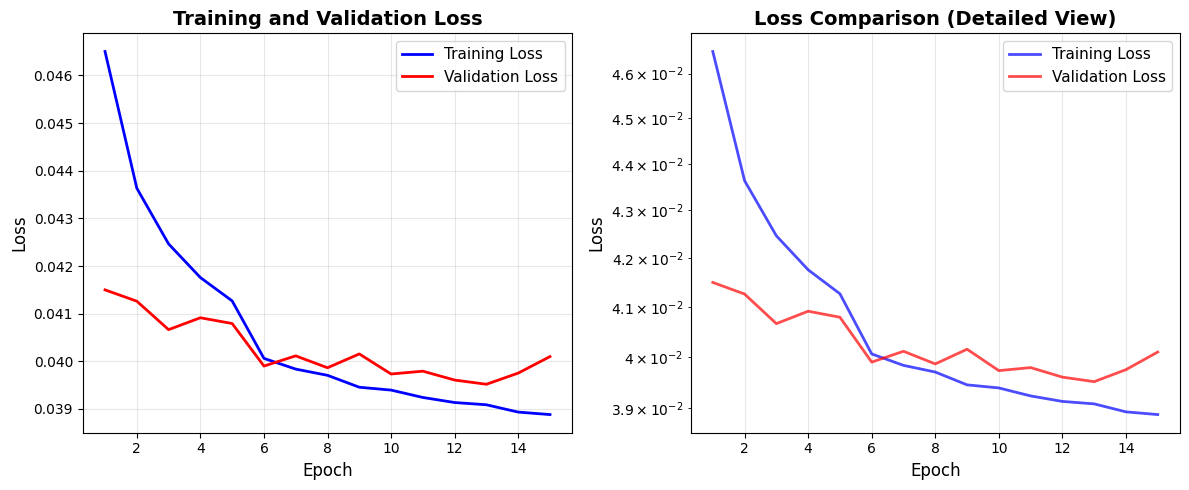


===== TRAINING SUMMARY =====
Final Training Loss: 0.0389
Final Validation Loss: 0.0401
Best Validation AUC: 0.8503
Total Epochs Trained: 15


In [24]:
# ---------------- PLOT TRAINING CURVES ---------------- #
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot validation AUC if available
if len(train_losses) > 0:
    plt.subplot(1, 2, 2)
    # We can't plot AUC here directly since we didn't store it, but we can show the loss comparison
    plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
    plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.7)
    plt.title('Loss Comparison (Detailed View)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

# Print loss summary
print("\n===== TRAINING SUMMARY =====")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Total Epochs Trained: {len(train_losses)}")
if patience_counter >= CONFIG["patience"]:
    print("Training stopped due to early stopping.")

In [25]:
# ---------------- TEST ---------------- #
best_checkpoint_path = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('best_model_')])[-1]
model.load_state_dict(torch.load(best_checkpoint_path))
test_stats = evaluate(model, testloader, criterion, CONFIG["device"])

[Test]:   0%|          | 0/575 [00:00<?, ?it/s]

[Test] Atelectasis AUC: 0.8220 | F1: 0.4146
[Test] Cardiomegaly AUC: 0.9335 | F1: 0.4871
[Test] Consolidation AUC: 0.7674 | F1: 0.2273
[Test] Edema AUC: 0.8947 | F1: 0.2955
[Test] Effusion AUC: 0.9012 | F1: 0.6076
[Test] Emphysema AUC: 0.9611 | F1: 0.4626
[Test] Fibrosis AUC: 0.7762 | F1: 0.1774
[Test] Hernia AUC: 0.9822 | F1: 0.7500
[Test] Infiltration AUC: 0.6986 | F1: 0.3925
[Test] Mass AUC: 0.8946 | F1: 0.4556
[Test] Nodule AUC: 0.7655 | F1: 0.3048
[Test] Pleural_Thickening AUC: 0.7576 | F1: 0.2450
[Test] Pneumonia AUC: 0.7442 | F1: 0.0664
[Test] Pneumothorax AUC: 0.8763 | F1: 0.3299
[Test] Avg AUC: 0.8411, Avg F1: 0.3726


In [26]:
print("\n===== TEST RESULTS =====")

# Overall metrics
print(f"Loss      : {test_stats['loss']:.4f}")
print(f"Avg AUROC : {test_stats['avg_auc']:.4f}")
print(f"Avg F1    : {test_stats['avg_f1']:.4f}")

# Per-class metrics
print("\n=== Per-Class Metrics ===")
print("{:<20} {:<10} {:<10} {:<10}".format("Class", "AUROC", "F1", "Threshold"))
print("-" * 55)
for cls in test_stats['auc_dict'].keys():
    auc = test_stats['auc_dict'][cls]
    f1  = test_stats['f1_dict'][cls]
    thr = test_stats['thresholds'][cls]
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(cls, auc, f1, thr))

# Optional: average threshold
avg_threshold = sum(test_stats['thresholds'].values()) / len(test_stats['thresholds'])
print("\nAverage Optimal Threshold across classes: {:.4f}".format(avg_threshold))



===== TEST RESULTS =====
Loss      : 0.0428
Avg AUROC : 0.8411
Avg F1    : 0.3726

=== Per-Class Metrics ===
Class                AUROC      F1         Threshold 
-------------------------------------------------------
Atelectasis          0.8220     0.4146     0.3751    
Cardiomegaly         0.9335     0.4871     0.4043    
Consolidation        0.7674     0.2273     0.3317    
Edema                0.8947     0.2955     0.3502    
Effusion             0.9012     0.6076     0.4265    
Emphysema            0.9611     0.4626     0.3068    
Fibrosis             0.7762     0.1774     0.3181    
Hernia               0.9822     0.7500     0.6953    
Infiltration         0.6986     0.3925     0.3989    
Mass                 0.8946     0.4556     0.3575    
Nodule               0.7655     0.3048     0.3429    
Pleural_Thickening   0.7576     0.2450     0.3138    
Pneumonia            0.7442     0.0664     0.1721    
Pneumothorax         0.8763     0.3299     0.3480    

Average Optimal Thresho

Generating predictions:   0%|          | 0/575 [00:00<?, ?it/s]

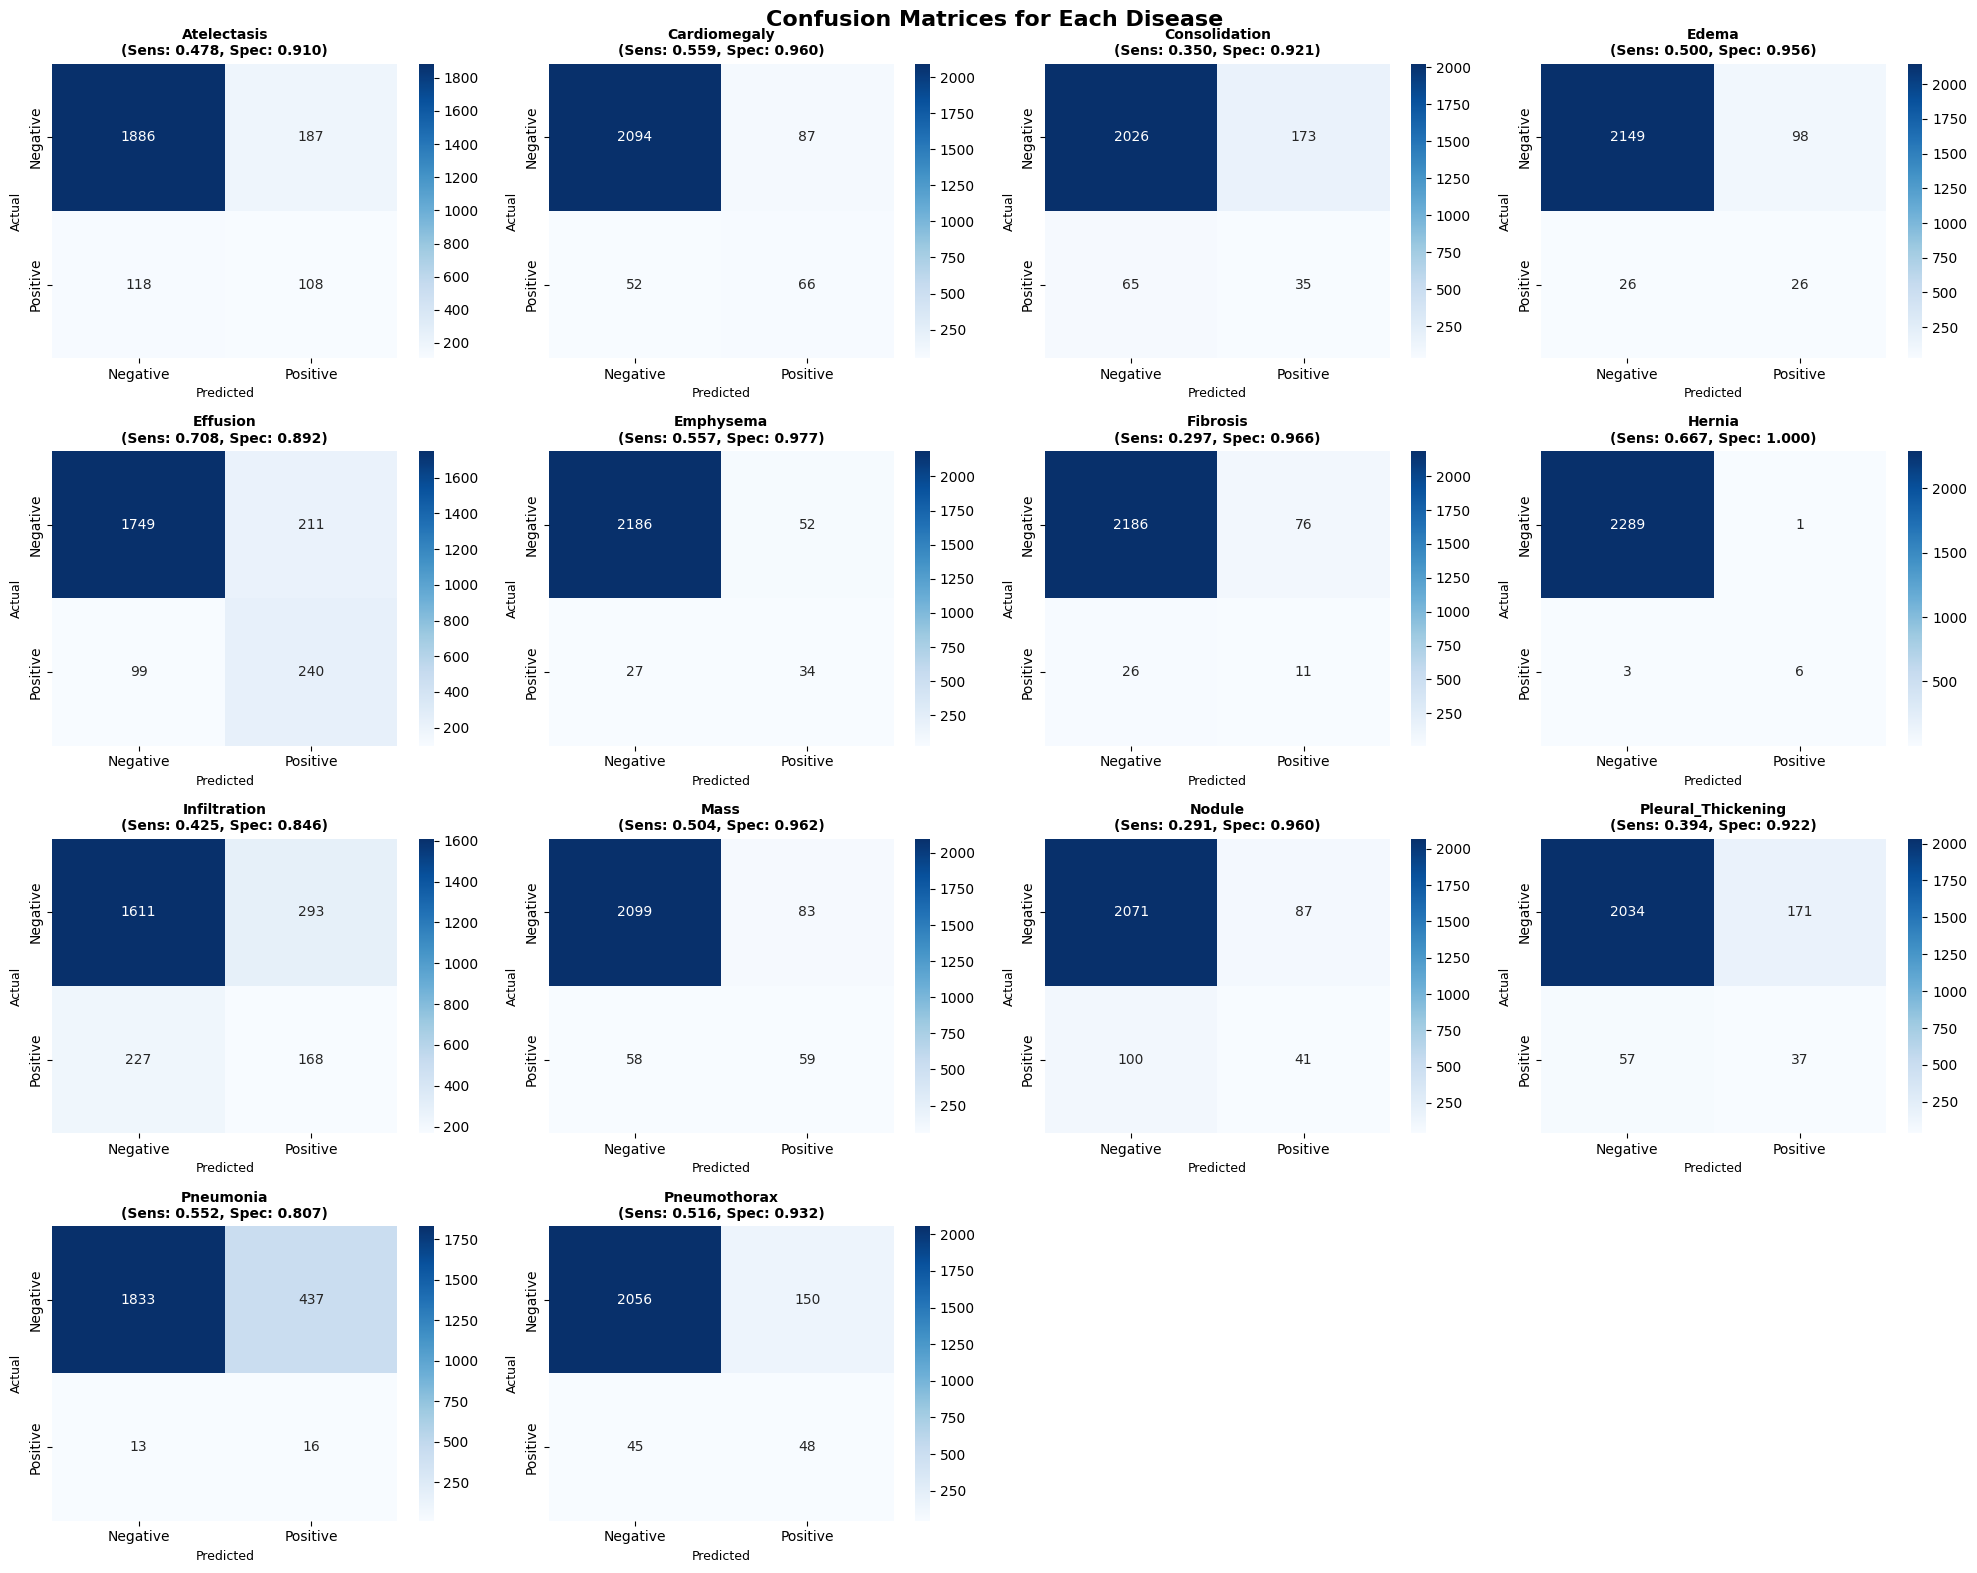

In [27]:
# ---------------- CONFUSION MATRIX ---------------- #
def generate_confusion_matrices(model, loader, device, thresholds):
    """
    Generate confusion matrices for multilabel classification.
    Since images can have multiple labels, we'll create individual confusion matrices for each disease.
    """
    model.eval()
    all_labels, all_preds = [], []
    
    print("Collecting predictions for confusion matrix...")
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Generating predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    
    # Convert predictions to binary using optimal thresholds
    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        threshold = thresholds[disease_list[i]]
        preds_binary[:, i] = (all_preds[:, i] > threshold).astype(int)
    
    # Create confusion matrices for each disease
    n_diseases = len(disease_list)
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    fig.suptitle('Confusion Matrices for Each Disease', fontsize=16, fontweight='bold')
    
    # Store confusion matrix metrics
    cm_metrics = {}
    
    for i, disease in enumerate(disease_list):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Generate confusion matrix for this disease
        cm = confusion_matrix(all_labels[:, i], preds_binary[:, i])
        
        # Calculate metrics
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        cm_metrics[disease] = {
            'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn),
            'Sensitivity': sensitivity, 'Specificity': specificity,
            'Precision': precision, 'NPV': npv
        }
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        ax.set_title(f'{disease}\n(Sens: {sensitivity:.3f}, Spec: {specificity:.3f})', 
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=9)
        ax.set_ylabel('Actual', fontsize=9)
    
    # Remove empty subplots (we have 14 diseases, so 2 empty spots)
    for i in range(n_diseases, 16):
        row = i // 4
        col = i % 4
        axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()
    
    return cm_metrics

# Generate confusion matrices using test data and optimal thresholds
cm_metrics = generate_confusion_matrices(model, testloader, CONFIG["device"], test_stats['thresholds'])

In [28]:
# ---------------- DETAILED CONFUSION MATRIX METRICS ---------------- #
print("\n===== DETAILED CONFUSION MATRIX METRICS =====")
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8} {:<8} {:<8} {:<8}".format(
    "Disease", "TP", "TN", "FP", "FN", "Sens", "Spec", "Prec", "NPV"))
print("-" * 100)

for disease, metrics in cm_metrics.items():
    print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
        disease, 
        metrics['TP'], metrics['TN'], metrics['FP'], metrics['FN'],
        metrics['Sensitivity'], metrics['Specificity'], 
        metrics['Precision'], metrics['NPV']
    ))

# Calculate and display average metrics
avg_sensitivity = np.mean([metrics['Sensitivity'] for metrics in cm_metrics.values()])
avg_specificity = np.mean([metrics['Specificity'] for metrics in cm_metrics.values()])
avg_precision = np.mean([metrics['Precision'] for metrics in cm_metrics.values()])
avg_npv = np.mean([metrics['NPV'] for metrics in cm_metrics.values()])

print("-" * 100)
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
    "AVERAGE", "-", "-", "-", "-", avg_sensitivity, avg_specificity, avg_precision, avg_npv))

print(f"\n===== SUMMARY =====")
print(f"Average Sensitivity (Recall): {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average NPV: {avg_npv:.4f}")

# Additional multilabel-specific metrics
print(f"\n===== MULTILABEL CHARACTERISTICS =====")
total_samples = len(testloader.dataset)
# Count samples with multiple labels
samples_with_multiple_labels = 0
samples_with_no_findings = 0

# Count samples with multiple labels and no findings
for labels in testloader.dataset.dataframe['Finding Labels']:
    label_vector = get_label_vector(labels)
    if sum(label_vector) == 0:
        samples_with_no_findings += 1
    elif sum(label_vector) > 1:
        samples_with_multiple_labels += 1

print(f"Samples with multiple labels: {samples_with_multiple_labels}")
print(f"Samples with no findings: {samples_with_no_findings}")
print(f"Total test samples: {total_samples}")
print("Note: This is a multilabel classification problem where each image can have multiple diseases simultaneously.")


===== DETAILED CONFUSION MATRIX METRICS =====
Disease              TP     TN     FP     FN     Sens     Spec     Prec     NPV     
----------------------------------------------------------------------------------------------------
Atelectasis          108    1886   187    118    0.478    0.910    0.366    0.941   
Cardiomegaly         66     2094   87     52     0.559    0.960    0.431    0.976   
Consolidation        35     2026   173    65     0.350    0.921    0.168    0.969   
Edema                26     2149   98     26     0.500    0.956    0.210    0.988   
Effusion             240    1749   211    99     0.708    0.892    0.532    0.946   
Emphysema            34     2186   52     27     0.557    0.977    0.395    0.988   
Fibrosis             11     2186   76     26     0.297    0.966    0.126    0.988   
Hernia               6      2289   1      3      0.667    1.000    0.857    0.999   
Infiltration         168    1611   293    227    0.425    0.846    0.364    0.876   
Ma